In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

In [43]:
Q = torch.tensor([[9.35, 0.41], [0.41, 0.02]])
R = torch.tensor([[1/500, 0], [0, 1/100]])
P = torch.tensor([[9.35, 0.41], [0.41, 0.02]])

params = [0.5734, 395.3268, 100e-3, 0.1, 72e+9, 8.314e+4, 8.314, 310, -4.78e+4, 0.239, 1000, 1]
CAs, Ts, CF, CV, Ck0, CE, CR, CT0, CDh, Ccp, Crho, CA0s = params                   
g = torch.tensor([[CF/CV, 0], [0, 1/(Crho*Ccp*CV)]])
g1, g2 = CF/CV, 1/(Crho*Ccp*CV)

u1b = 2
u2b = 0.167

In [44]:
class Value(nn.Module):
    def __init__(self):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(2, 256, bias=False)
        self.fc2 = nn.Linear(256, 256, bias=False)
        self.output = nn.Linear(256, 2, bias=False)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.output(x)
        return torch.sum(x*x, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(2, 256, bias=False)
        self.fc2 = nn.Linear(256, 256, bias=False)
        self.output = nn.Linear(256, 2, bias=False)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.output(x))
        return x*torch.tensor([u1b, u2b])

In [45]:
stop = 10**(-4)
num_epochs = 10**3

torch.manual_seed(0)
fir = np.linspace(-1, 1, 100)
sec = np.linspace(-20.0, 20.0, 400)
x = []
for i in fir:
    for j in sec:
        t = torch.tensor([i, j]).to(torch.float32)
        if torch.sum(t@P*t)<0.3:
            x.append([i, j])
x = torch.tensor(x, requires_grad=True).to(torch.float32)
len(x)

3394

In [46]:
def getH(x, value, policy):
    x1, x2 = x.T[0].detach().numpy(), x.T[1].detach().numpy()
    u = policy.forward(x)
    
    l = torch.sum(x@Q*x, 1) + torch.sum(u@R*u, 1)
    f1 = (CF/CV)*(-x1) - Ck0*np.exp(-CE/(CR*(x2+Ts))) * (x1+CAs)+(CF/CV) * (CA0s-CAs)
    f2 = (CF/CV)*(-x2) + (-CDh/(Crho*Ccp))*Ck0*np.exp(-CE/(CR*(x2+Ts)))*(x1+CAs) + CF*(CT0-Ts)/CV
    f = np.array([f1, f2])
    f = torch.tensor(f).T + u@g

    V_hat = value.forward(x)
    grad_VX = torch.autograd.grad(outputs=V_hat, inputs=x, grad_outputs=torch.ones_like(V_hat), create_graph=True)
    dVdX = grad_VX[0]
    
    H = l + torch.sum(f*dVdX, 1)
    return H

RCTAC

In [47]:
value = Value()
policy = Policy()

optimizer1 = torch.optim.Adam(value.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(policy.parameters(), lr=1e-4)
optimizer3 = torch.optim.Adam(policy.parameters(), lr=1e-3)

In [18]:
print(f'########################## Warm Up ##############################')
dt = 0.001
V = torch.sum(x@P*x, 1)
for epoch in range(10**4):
    optimizer3.zero_grad()
    u = policy.forward(x)
    x1, x2 = x.T[0].detach().numpy(), x.T[1].detach().numpy()
    f1 = (CF/CV)*(-x1) - Ck0*np.exp(-CE/(CR*(x2+Ts))) * (x1+CAs)+(CF/CV) * (CA0s-CAs)
    f2 = (CF/CV)*(-x2) + (-CDh/(Crho*Ccp))*Ck0*np.exp(-CE/(CR*(x2+Ts)))*(x1+CAs) + CF*(CT0-Ts)/CV
    f = torch.tensor(np.array([f1, f2])).T
    dx = f + u@g
    x1 = x + dx*dt
    V1 = torch.sum(x1@P*x1, 1)
    loss = torch.mean(F.relu(V1-V*0.99))
    if epoch%1000 == 0:
        print(f'Epoch:{epoch}, Loss:{loss}')
    loss.backward(retain_graph=True)
    optimizer3.step()
torch.save(policy, 'initial_policy')

########################## Warm Up ##############################
Epoch:0, Loss:0.0018801731057465076
Epoch:1000, Loss:0.00011674359848257154
Epoch:2000, Loss:0.00011226350761717185
Epoch:3000, Loss:0.00011113329674117267
Epoch:4000, Loss:0.00011068437015637755
Epoch:5000, Loss:0.00011047784937545657
Epoch:6000, Loss:0.00011036249634344131
Epoch:7000, Loss:0.00011029384768335149
Epoch:8000, Loss:0.00011029325105482712
Epoch:9000, Loss:0.00011026154970750213


In [49]:
path = '_at_epoch1'
value = torch.load('value'+path)
policy = torch.load('policy'+path)

optimizer1 = torch.optim.Adam(value.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(policy.parameters(), lr=1e-4)

In [50]:
for epoch in range(10):
    epoch=epoch+2
    print(f'Epoch: {epoch}')
    print(f'#################### Value Iteration #####################')
    for i in range(1000):
        optimizer1.zero_grad()
        H = getH(x, value, policy)
        Lc = torch.mean(H**2)
        if i%100==0:
            print(f'E[H^2]:{Lc}')
        Lc.backward(retain_graph=True)
        optimizer1.step()
    print(f'#################### Policy Iteration #####################')
    for i in range(1000):
        optimizer2.zero_grad()
        H = getH(x, value, policy)
        La_new = torch.mean(H)
        if i%100==0:
            print(f'E[H]:{La_new}')
        La_new.backward(retain_graph=True)
        optimizer2.step()
    torch.save(value, f'value_at_epoch{epoch}')
    torch.save(policy, f'policy_at_epoch{epoch}')

Epoch: 2
#################### Value Iteration #####################
E[H^2]:0.0039765420369803905
E[H^2]:0.004005480092018843
E[H^2]:0.003976314794272184
E[H^2]:0.00397012522444129
E[H^2]:0.003965943586081266
E[H^2]:0.003962162882089615
E[H^2]:0.003958463668823242
E[H^2]:0.003954798448830843
E[H^2]:0.003951170947402716
E[H^2]:0.003947581630200148
#################### Policy Iteration #####################
E[H]:0.008370998315513134
E[H]:0.007711943704634905
E[H]:0.007607150822877884
E[H]:0.007361349184066057
E[H]:0.007353318389505148
E[H]:0.007349641993641853
E[H]:0.00734693231061101
E[H]:0.007344977464526892
E[H]:0.0073435646481812
E[H]:0.007342510856688023
Epoch: 3
#################### Value Iteration #####################
E[H^2]:0.0037301797419786453
E[H^2]:0.0036025503650307655
E[H^2]:0.0035912971943616867
E[H^2]:0.003582679433748126
E[H^2]:0.003575304988771677
E[H^2]:0.003568616695702076
E[H^2]:0.003562327940016985
E[H^2]:0.003556283190846443
E[H^2]:0.003550396766513586
E[H^2]:0.003

KeyboardInterrupt: 

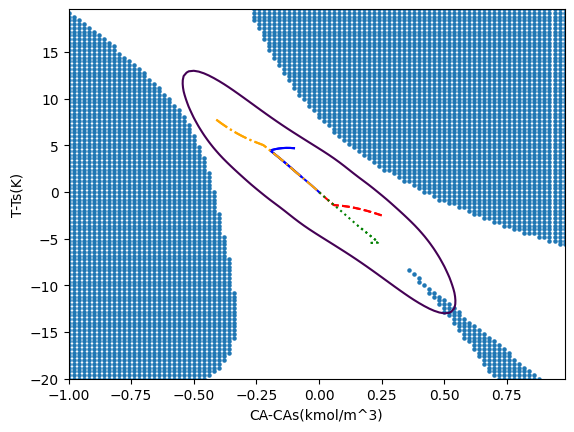

In [90]:
path = '_at_epoch9'
value = torch.load('value'+path)
policy = torch.load('policy'+path)
fig, ax = plt.subplots()
ax.set_xlabel('CA-CAs(kmol/m^3)')
ax.set_ylabel('T-Ts(K)')

#time run check
s1, s2, s3, s4 = torch.tensor([0.25, -2.5]), torch.tensor([-0.1,  4.7]), torch.tensor([2.0633e-01, -5.4529e+00]), torch.tensor([-0.41007,  7.7541])
dt = 0.001
t = 10
xpoints, ypoints = [], []
for s in [s1, s2, s3, s4]:
    sa, sb = [], []
    for i in range(int(t/dt)):
        temp = s.detach().numpy()
        sa.append(temp[0]), sb.append(temp[1])
        s11, s12 = s[0].detach().numpy(), s[1].detach().numpy()
        f11 = (CF/CV)*(-s11) - Ck0*np.exp(-CE/(CR*(s12+Ts))) * (s11+CAs)+(CF/CV) * (CA0s-CAs)
        f12 = (CF/CV)*(-s12) + (-CDh/(Crho*Ccp))*Ck0*np.exp(-CE/(CR*(s12+Ts)))*(s11+CAs) + CF*(CT0-Ts)/CV
        u = policy.forward(s)
        u1, u2 = u.detach().numpy()
        ds1, ds2 = f11 + g1*u1, f12 + g2*u2
        s = s + torch.tensor([ds1, ds2], dtype=torch.float32)*dt
    xpoints.append(sa)
    ypoints.append(sb)

# plot trajectories for initial states
color = ['red', 'blue', 'green', 'orange']
linestyle = ['--', '-', 'dotted', '-.']
ax.plot(xpoints[0][:400], ypoints[0][:400], color=color[0], linestyle=linestyle[0])
ax.plot(xpoints[1][:400], ypoints[1][:400], color=color[1], linestyle=linestyle[1])
ax.plot(xpoints[2][:400], ypoints[2][:400], color=color[2], linestyle=linestyle[2])
ax.plot(xpoints[3][:400], ypoints[3][:400], color=color[3], linestyle=linestyle[3])
for i in range(4):
    ax.plot(xpoints[i], ypoints[i], color=color[i], linestyle=linestyle[i])

A, B = [], []
# plot level set V=0.2
xx = np.arange(-1, 1, 0.02)
yy = np.arange(-20, 20, 0.4)
xx, yy = np.meshgrid(xx, yy)
Z, V = np.zeros(xx.shape), np.zeros(xx.shape)
for i in range(len(xx)):
    for j in range(len(xx[0])):
        x1, x2 = xx[i][j], yy[i][j]
        f1 = (CF/CV)*(-x1) - Ck0*np.exp(-CE/(CR*(x2+Ts))) * (x1+CAs)+(CF/CV) * (CA0s-CAs)
        f2 = (CF/CV)*(-x2) + (-CDh/(Crho*Ccp))*Ck0*np.exp(-CE/(CR*(x2+Ts)))*(x1+CAs) + CF*(CT0-Ts)/CV
        f = torch.tensor(np.array([f1, f2])).T
        x1 = torch.tensor([x1]).to(torch.float32)
        x2 = torch.tensor([x2]).to(torch.float32)
        X = torch.cat((x1, x2))
        dVdx = 2*X@P
        u = policy.forward(X)
        dx = f + u@g
        if torch.sum(dVdx*dx)>0:
            A.append(xx[i][j])
            B.append(yy[i][j])
        V[i][j] = torch.sum(X*torch.matmul(X, P))
        Z[i][j] = value.forward(X[None,:])
    
plt.scatter(A, B, s=5)
#plt.contour(xx, yy, V, [0.3])
plt.contour(xx, yy, Z, [0.025])
plt.savefig('policy'+path+'.jpg')
plt.show()

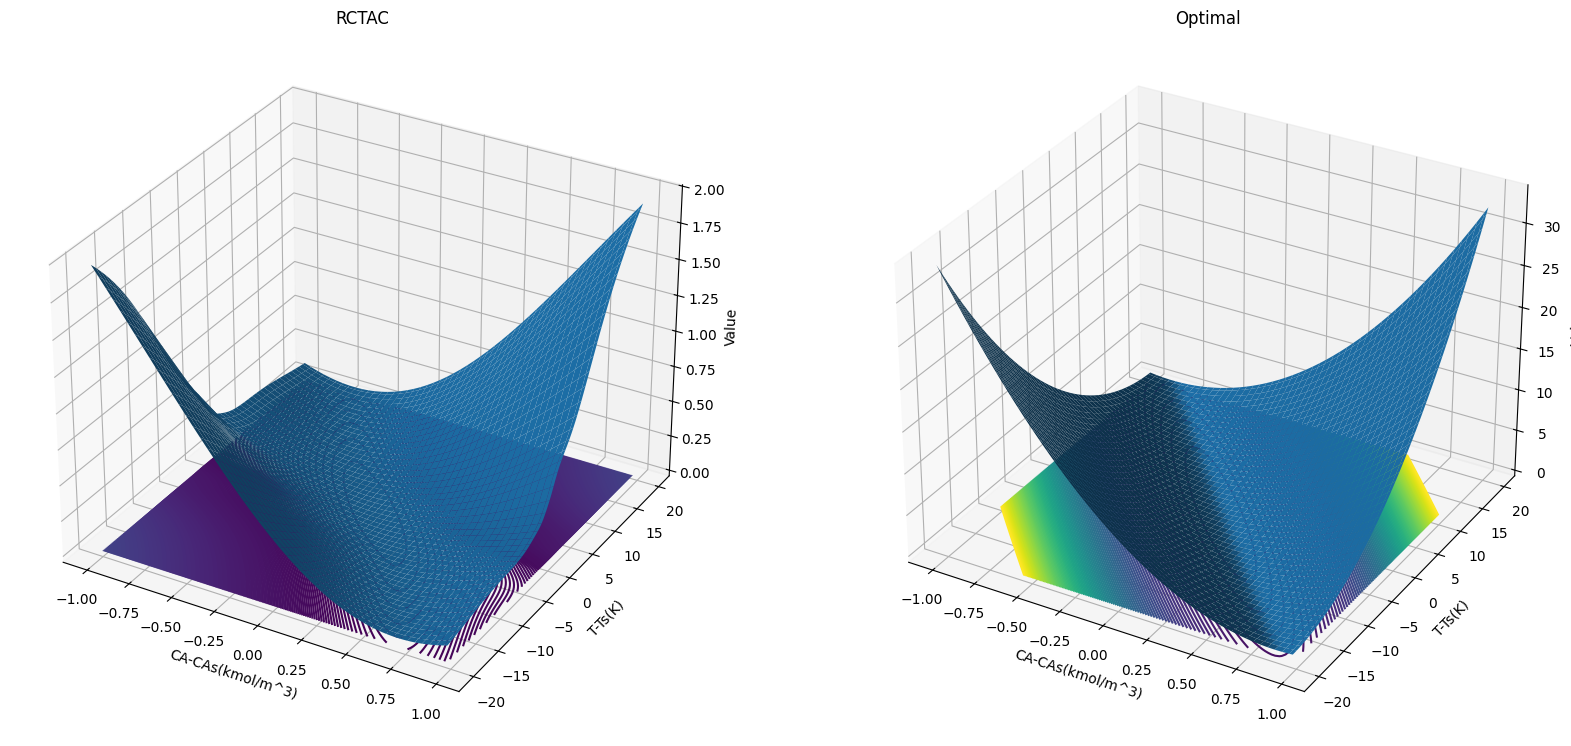

In [68]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
for ax in [ax1, ax2]:
    ax.set_xlabel('CA-CAs(kmol/m^3)')
    ax.set_ylabel('T-Ts(K)')
    ax.set_zlabel('Value')

ax1.plot_surface(xx, yy, Z)
ax1.contour(xx, yy, Z, np.arange(0, 10, 0.01), offset=np.min(Z))
ax1.set_title('RCTAC')
ax2.plot_surface(xx, yy, V)
ax2.contour(xx, yy, V, np.arange(0, 20, 0.2), offset=np.min(V))
ax2.set_title('Optimal')

plt.savefig('value'+path+'.jpg')
plt.show()